In [1]:
import cv2
from pytorchyolo import detect, models
import numpy as np
import random

# Load the YOLO model
model = models.load_model(
  "config\yolov3-tiny.cfg", 
  "weights\yolov3-tiny.weights")

# Load the image as a numpy array
img = cv2.imread("dog.png")

# Convert OpenCV bgr to rgb
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Runs the YOLO model on the image 
boxes = detect.detect_image(model, img)

print(boxes)
# Output will be a numpy array in the following format:
# [[x1, y1, x2, y2, confidence, class]]

anchors [(81, 82), (135, 169), (344, 319)]
anchors [(23, 27), (37, 58), (81, 82)]
[[2.0851854e+02 1.5740225e+02 5.6922607e+02 4.4380756e+02 7.0234644e-01
  1.0000000e+00]
 [4.8276605e+02 9.0100395e+01 6.6730396e+02 1.6982370e+02 6.2609506e-01
  7.0000000e+00]
 [4.6602338e+02 8.1570305e+01 6.7463763e+02 1.6935039e+02 5.9431064e-01
  2.0000000e+00]
 [1.2829146e+02 1.8268472e+02 3.7209848e+02 5.1320990e+02 5.3308415e-01
  1.6000000e+01]]


In [2]:
def plot_bbox(img, bboxes, scores=None, labels=None, thresh=0.5,
              class_names=None, colors=None, ax=None,
              reverse_rgb=False, absolute_coordinates=True,
              linewidth=3.5, fontsize=12):
    """Visualize bounding boxes.

    Parameters
    ----------
    img : numpy.ndarray or mxnet.nd.NDArray
        Image with shape `H, W, 3`.
    bboxes : numpy.ndarray or mxnet.nd.NDArray
        Bounding boxes with shape `N, 4`. Where `N` is the number of boxes.
    scores : numpy.ndarray or mxnet.nd.NDArray, optional
        Confidence scores of the provided `bboxes` with shape `N`.
    labels : numpy.ndarray or mxnet.nd.NDArray, optional
        Class labels of the provided `bboxes` with shape `N`.
    thresh : float, optional, default 0.5
        Display threshold if `scores` is provided. Scores with less than `thresh`
        will be ignored in display, this is visually more elegant if you have
        a large number of bounding boxes with very small scores.
    class_names : list of str, optional
        Description of parameter `class_names`.
    colors : dict, optional
        You can provide desired colors as {0: (255, 0, 0), 1:(0, 255, 0), ...}, otherwise
        random colors will be substituted.
    ax : matplotlib axes, optional
        You can reuse previous axes if provided.
    reverse_rgb : bool, optional
        Reverse RGB<->BGR orders if `True`.
    absolute_coordinates : bool
        If `True`, absolute coordinates will be considered, otherwise coordinates
        are interpreted as in range(0, 1).
    linewidth : float, optional, default 3.5
        Line thickness for bounding boxes.
    fontsize : int, optional, default 12
        Font size for display of class labels and threshold.

    Returns
    -------
    matplotlib axes
        The ploted axes.

    """
    from matplotlib import pyplot as plt

    if labels is not None and not len(bboxes) == len(labels):
        raise ValueError('The length of labels and bboxes mismatch, {} vs {}'
                         .format(len(labels), len(bboxes)))
    if scores is not None and not len(bboxes) == len(scores):
        raise ValueError('The length of scores and bboxes mismatch, {} vs {}'
                         .format(len(scores), len(bboxes)))

    ax = plot_image(img, ax=ax, reverse_rgb=reverse_rgb)

    if len(bboxes) < 1:
        return ax

    #if mx is not None and isinstance(bboxes, mx.nd.NDArray):
    #    bboxes = bboxes.asnumpy()
    #if mx is not None and isinstance(labels, mx.nd.NDArray):
    #    labels = labels.asnumpy()
    #if mx is not None and isinstance(scores, mx.nd.NDArray):
    #    scores = scores.asnumpy()

    if not absolute_coordinates:
        # convert to absolute coordinates using image shape
        height = img.shape[0]
        width = img.shape[1]
        bboxes[:, (0, 2)] *= width
        bboxes[:, (1, 3)] *= height

    # use random colors if None is provided
    if colors is None:
        colors = dict()
    for i, bbox in enumerate(bboxes):
        if scores is not None and scores.flat[i] < thresh:
            continue
        if labels is not None and labels.flat[i] < 0:
            continue
        cls_id = int(labels.flat[i]) if labels is not None else -1
        if cls_id not in colors:
            if class_names is not None:
                colors[cls_id] = plt.get_cmap('hsv')(cls_id / len(class_names))
            else:
                colors[cls_id] = (random.random(), random.random(), random.random())
        xmin, ymin, xmax, ymax = [int(x) for x in bbox]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                             ymax - ymin, fill=False,
                             edgecolor=colors[cls_id],
                             linewidth=linewidth)
        ax.add_patch(rect)
        if class_names is not None and cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = str(cls_id) if cls_id >= 0 else ''
        score = '{:.3f}'.format(scores.flat[i]) if scores is not None else ''
        if class_name or score:
            ax.text(xmin, ymin - 2,
                    '{:s} {:s}'.format(class_name, score),
                    bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                    fontsize=fontsize, color='white')
    return ax

def plot_image(img, ax=None, reverse_rgb=False):
    """Visualize image.

    Parameters
    ----------
    img : numpy.ndarray or mxnet.nd.NDArray
        Image with shape `H, W, 3`.
    ax : matplotlib axes, optional
        You can reuse previous axes if provided.
    reverse_rgb : bool, optional
        Reverse RGB<->BGR orders if `True`.

    Returns
    -------
    matplotlib axes
        The ploted axes.

    Examples
    --------

    from matplotlib import pyplot as plt
    ax = plot_image(img)
    plt.show()
    """
    from matplotlib import pyplot as plt
    if ax is None:
        # create new axes
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    #if mx is not None and isinstance(img, mx.nd.NDArray):
    #    img = img.asnumpy()
    img = img.copy()
    if reverse_rgb:
        img[:, :, (0, 1, 2)] = img[:, :, (2, 1, 0)]
    ax.imshow(img.astype(np.uint8))
    return ax

In [3]:
boxes[:,:-2]

array([[208.51854 , 157.40225 , 569.2261  , 443.80756 ],
       [482.76605 ,  90.100395, 667.30396 , 169.8237  ],
       [466.02338 ,  81.570305, 674.63763 , 169.35039 ],
       [128.29146 , 182.68472 , 372.09848 , 513.2099  ]], dtype=float32)

<AxesSubplot:>

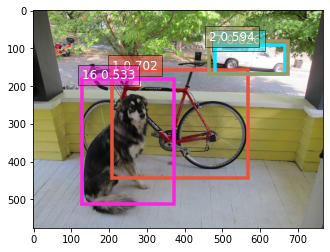

In [4]:
plot_bbox(img,boxes[:,:-2],scores=boxes[:,-2],labels=boxes[:,-1])